In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import Constant

# Read the CSV file
data = pd.read_csv('NLP_DATASET.csv', encoding='utf-8')

In [16]:
# Balance the dataset
emotion_counts = data['Emotion'].value_counts()
max_samples = emotion_counts.max()

In [17]:
print(emotion_counts)

Emotion
sadness    2708
joy        2700
anger      2637
fear       2573
neutral    1616
disgust    1067
shame      1054
guilt      1052
Name: count, dtype: int64


<ipython-input-18-ab6fcd9a4c5c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')


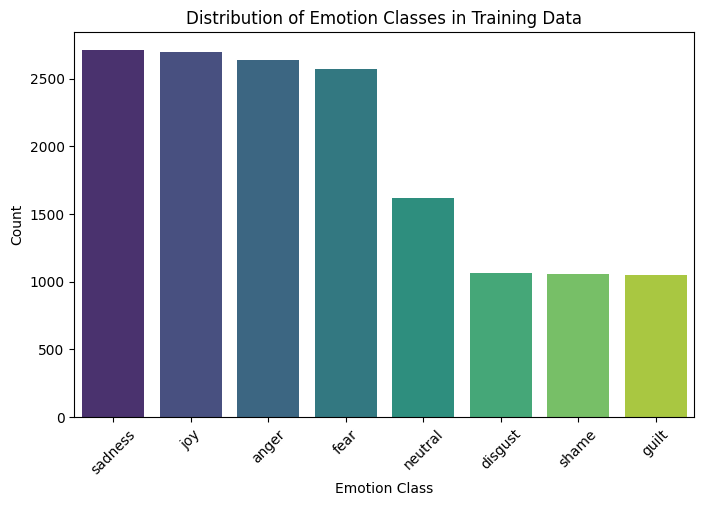

In [18]:
# Create a bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
plt.xlabel('Emotion Class')
plt.ylabel('Count')
plt.title('Distribution of Emotion Classes in Training Data')
plt.xticks(rotation=45)
plt.show()


In [19]:
upsampled_data = pd.concat([resample(data[data['Emotion'] == emotion],
                                    replace=True,
                                    n_samples=max_samples,
                                    random_state=42)
                           for emotion in emotion_counts.index])

In [20]:
# Splitting the upsampled dataset into training and testing sets
train_data, test_data = train_test_split(upsampled_data, test_size=0.2, random_state=42)

In [26]:
print(train_data.Emotion.value_counts())

Emotion
sadness    2205
disgust    2176
fear       2172
neutral    2171
joy        2155
guilt      2154
shame      2149
anger      2149
Name: count, dtype: int64


In [22]:
print(test_data.Emotion.value_counts())

Emotion
anger      559
shame      559
guilt      554
joy        553
neutral    537
fear       536
disgust    532
sadness    503
Name: count, dtype: int64


<ipython-input-23-c70be6b5eddb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')


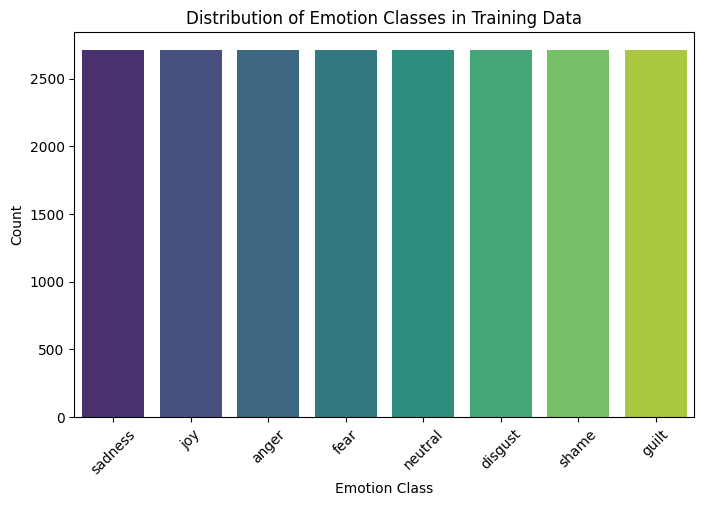

In [23]:
emotion_counts = upsampled_data['Emotion'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
plt.xlabel('Emotion Class')
plt.ylabel('Count')
plt.title('Distribution of Emotion Classes in Training Data')
plt.xticks(rotation=45)
plt.show()


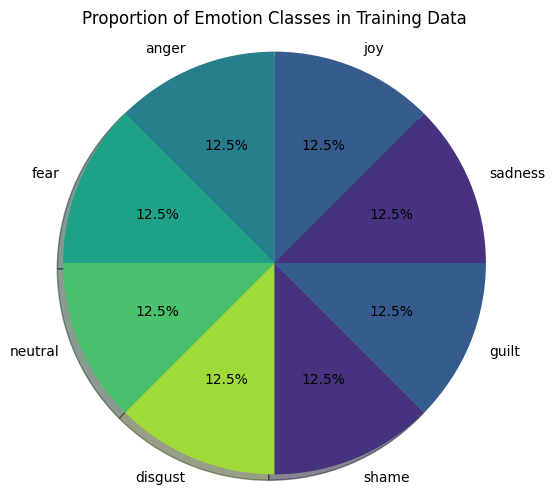

In [24]:
# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'), shadow=True)
plt.title('Proportion of Emotion Classes in Training Data')
plt.axis('equal')
plt.show()


In [27]:
# Feature Engineering
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['Text'])
word_index = tokenizer.word_index

In [28]:
train_sequences = tokenizer.texts_to_sequences(train_data['Text'])
test_sequences = tokenizer.texts_to_sequences(test_data['Text'])

In [29]:
##uncomment to save the tokenizer file

# import pickle

# # Save tokenizer and word index to files
# with open('tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f)

# print("Tokenizer saved to files.")


Tokenizer saved to files.


In [30]:
# Padding sequences
max_length = 350
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Encoding labels
encoding = {'joy': 0, 'sadness': 1, 'fear': 2, 'anger': 3, 'disgust': 4, 'shame': 5, 'guilt': 6, 'neutral': 7}
train_labels = train_data['Emotion'].map(encoding)
test_labels = test_data['Emotion'].map(encoding)


In [31]:
import gensim.downloader as api
from tensorflow.keras.regularizers import l2

# Load Word2Vec word embeddings
word_vectors = api.load("word2vec-google-news-300")

# Create embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word_vectors.key_to_index:  # Check if the word exists in the vocabulary
        embedding_matrix[i] = word_vectors[word]

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [35]:
# Define the model with L2 regularization and dropout in two steps
model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim,
              embeddings_initializer=Constant(embedding_matrix),
              input_length=max_length,
              trainable=True),  # Set trainable=True to fine-tune embeddings
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01))),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),  # First dropout layer with 30% dropout rate
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),  # First dropout layer with 30% dropout rate
    Dense(8, activation='softmax')
])

In [36]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Hyperparameter Tuning
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)


In [37]:
# Train the model
history = model.fit(train_padded, train_labels,
                    epochs=100,
                    batch_size=128,
                    validation_data=(test_padded, test_labels),
                    callbacks=[early_stopping])


Epoch 1/100
136/136 [==============================] - 331s 2s/step - loss: 3.8679 - accuracy: 0.2266 - val_loss: 1.9583 - val_accuracy: 0.2825
Epoch 2/100
136/136 [==============================] - 323s 2s/step - loss: 1.8402 - accuracy: 0.3363 - val_loss: 1.6277 - val_accuracy: 0.4480
Epoch 3/100
136/136 [==============================] - 316s 2s/step - loss: 1.5679 - accuracy: 0.4551 - val_loss: 1.4350 - val_accuracy: 0.5084
Epoch 4/100
136/136 [==============================] - 312s 2s/step - loss: 1.3593 - accuracy: 0.5416 - val_loss: 1.3011 - val_accuracy: 0.5707
Epoch 5/100
136/136 [==============================] - 317s 2s/step - loss: 1.2258 - accuracy: 0.6056 - val_loss: 1.1665 - val_accuracy: 0.6637
Epoch 6/100
136/136 [==============================] - 308s 2s/step - loss: 1.1068 - accuracy: 0.6648 - val_loss: 1.1127 - val_accuracy: 0.6951
Epoch 7/100
136/136 [==============================] - 311s 2s/step - loss: 1.0347 - accuracy: 0.7046 - val_loss: 1.0484 - val_accuracy:

In [38]:
# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)



136/136 [==============================] - 27s 200ms/step - loss: 0.8901 - accuracy: 0.8091
Test Loss: 0.8900728225708008
Test Accuracy: 0.8091391921043396


In [ ]:
# Predict probabilities for each class
predicted_probabilities = model.predict(test_padded)

# Convert probabilities to class labels
predictions = np.argmax(predicted_probabilities, axis=1)

# Classification Report
print(classification_report(test_labels, predictions))


In [40]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions)
print(conf_matrix)

[[411  55   4  11   2   3  21  46]
 [ 23 386  22  32   0   5  23  12]
 [  5  23 446  38   8   2   7   7]
 [ 10  11  10 427  12  33  36  20]
 [  1   5  10  73 421  14   8   0]
 [  2   4   6  33   6 420  88   0]
 [  6  13   4  23   0  16 492   0]
 [ 12   2   2  14   0   1   3 503]]
[[411  55   4  11   2   3  21  46]
 [ 23 386  22  32   0   5  23  12]
 [  5  23 446  38   8   2   7   7]
 [ 10  11  10 427  12  33  36  20]
 [  1   5  10  73 421  14   8   0]
 [  2   4   6  33   6 420  88   0]
 [  6  13   4  23   0  16 492   0]
 [ 12   2   2  14   0   1   3 503]]


In [41]:
# Save the model
model.save("emotion_detection_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
# Tokenize and pad user input
def preprocess_input(text):
    # Tokenize input text
    sequence = tokenizer.texts_to_sequences([text])
    # Pad sequences
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    return padded_sequence

# Map predicted label index to emotion
def map_label_to_emotion(label_index):
    mapping = {0: 'joy', 1: 'sadness', 2: 'fear', 3: 'anger', 4: 'disgust', 5: 'shame', 6: 'guilt', 7: 'neutral'}
    return mapping[label_index]




In [45]:
while True:
    # Get user input
    user_input = input("Enter text to classify emotion (type 'end' to exit): ")

    # Check if user wants to end the task
    if user_input.lower() == 'end':
        print("Exiting...")
        break

    # Preprocess input
    processed_input = preprocess_input(user_input)

    # Predict emotion probabilitiesh
    emotion_probabilities = model.predict(processed_input)[0]

    # Get the index of the emotion with the highest probability
    predicted_label_index = np.argmax(emotion_probabilities)

    # Map the predicted label index to the corresponding emotion
    predicted_emotion = map_label_to_emotion(predicted_label_index)

    print("Predicted emotion:", predicted_emotion)

Enter text to classify emotion (type 'end' to exit): The way he treats people is absolutely revolting
1/1 [==============================] - 0s 182ms/step
Predicted emotion: anger
Enter text to classify emotion (type 'end' to exit): Walking alone in the dark alley terrifies me.
1/1 [==============================] - 0s 179ms/step
Predicted emotion: fear
Enter text to classify emotion (type 'end' to exit): I feel so embarrassed about my mistake.
1/1 [==============================] - 0s 261ms/step
Predicted emotion: shame
Enter text to classify emotion (type 'end' to exit): I am furious about the unfair treatment at work.
1/1 [==============================] - 0s 207ms/step
Predicted emotion: anger
Enter text to classify emotion (type 'end' to exit): i didnt complete my work today i dont know whats going to happen
1/1 [==============================] - 0s 316ms/step
Predicted emotion: fear
Enter text to classify emotion (type 'end' to exit): end
Exiting...
